# LED Control Algorithm
_Considering in Junction Temperature_

20180312 by DymaxionKim

## 개요
* 프로젝트 : [FAT3]
* 목표 : IR LED의 온도에 따른 도 변화를 반영하고, 적분을 통해 광조사시간을 결정하는 알고리즘 수립

## 계획
### 전제조건 및 모델
* IR LED 접합부 온도와 광출력밀도간 함수관계가 성립한다.
* 온도센서와 IR LED 접합부 간의 온도차이도 함수관계가 성립한다.  이때, 평형상태로  접합부 간의 온도차이도 함수관계가 성립한다.  이때, 항상 평형상태로 평형상태라고 가정한다.
* 위 2가지 데이타를 이용하여 IR LED 접합부 온도를 생략하고, 온도센서와 광출력밀도간 함수로 간소화한다.
* IR LED의 접합부 온도는, CAE를 통해 얻어낸 정보를 사용하고, 온도와 광출력밀도의 관계는 실측데이타를 가공하여 적용한다.
* 적분은 영차 보간을 통한 이산화 기법을 적용하여 근사화한다.
* MCU에서 직접 부동소수점 연산이 곤란하므로, 얻어낸 정보를 정수화한 테이블로 정리한다.

### IR LED 접합부 온도와 광출력밀도간 함수

|![Junction](https://raw.githubusercontent.com/dymaxionkim/My-Jupyter-Notebooks/master/PIC/20180312_FAT3_LED_Control_Algorithm_Junction.png) | ![Sensor](https://raw.githubusercontent.com/dymaxionkim/My-Jupyter-Notebooks/master/PIC/20180312_FAT3_LED_Control_Algorithm_Sensor.png)|
|:---:|:---:|
|Junction|Sensor|

* CAE 천이 해석 결과를 이용하여, 기동 직후부터 시간에 따른 온도변화를 데이타화 한다.
* 한편, 실측된 시간에 따른 광출력밀도 데이타도 함께 준비한다.
* 각 시간대별로 IR LED 접합부 온도를 규명하고, 그에 따른 광출력밀도를 알아낸다.
* 이상의 정보를 이용하여, IR LED 접합부 온도와 광출력밀도간 함수를 얻어낸다.

### 온도센서와 IR LED 접합부간의 온도차 함수
* 상온에서 최초 시작시, IR LED 온도가 빠르게 올라가고 이후에 온도센서 온도가 올라가는 천이영역의 시간대가 존재할 것이다.  그러나 둘 사이를 매개하는 PCB의 두께가 얇고 가까우므로, 천이영역의 시간대는 무시할 만큼 짧다고 가정한다.  따라서 항상 평형상태로 본다.
* CAE 천이 해석 결과를 보고, IR LED 접합부 온도에 따른 온도센서의 값을 추출해 내어 테이블화 한다.
* 테이블을 그래프화한다.  보간은 LU Decomposition 기법을 사용한다.

### 온도센서와 광출력밀도간 함수
* 위 2가지 결과를 이용하여, 온도센서와 광출력밀도간 함수를 얻어낸다.

### 데이타 정수화
* 앞서 얻어낸 함수값의 범위를 128단계로 쪼개고 정수화한 후, 테이블화 한다.
* 만일 정보가 너무 많다면 단계를 더 줄인다. (메모리 여유 공간 확인)

### 적분
* MPU의 타이머 인터럽트 반복시간을 정의한다.
* 원하는 투여량을 정의한다. (정수화된 값으로 정의할 것)  대략 0.2[W/cm^2]x15[min]x60[sec]=180[J/cm^2] 정도로 한다.
* 현재의 온도센서값을 읽어들이고, 이에 대응하는 광출력밀도를 알아낸다.
* 현재의 광출력밀도값과 타이머 인터럽트 반복시간을 곱한다. (정수화할 것)
* 이전의 적분값에 새로 얻어낸 값을 더한다.
* 계속 누적된 적분값이 원하는 투여량에 도달했는지 판단하고, 도달했으면 종료한다.
* 한편, 온도리밋값도 적용하여, 지정값 이상으로 온도센서값이 올라가면 IR LED를 끄고 식을 때 까지 광출력밀도값은 0으로 놓고 계속 적분한다.  물론 식으면 다시 키고 적분을 계속해서 투여량에 도달하도록 한다.

### 요약
* 온도센서에서 읽어낸 보정값을 반영한 광출력밀도값을 적분하여, 원하는 투여량에 도달할 때 까지 작동하도록 제어한다.
* 온도에 따른 LED의 효율도 별도로 추산해 두고, 관계식도 정의해 두자. (나중에 정확한 데이타시트가 주어지면 쉽게 변경 가능하도록)

In [3]:
# Julia Code
# Plotter
using PyPlot
PyPlot.svg(true)

# Cubic Spline Interpolator : https://github.com/kbarbary/Dierckx.jl
using Dierckx

# Curve Fitting : https://github.com/pjabardo/CurveFit.jl
using CurveFit

## Time vs LPD(Light Power Density)

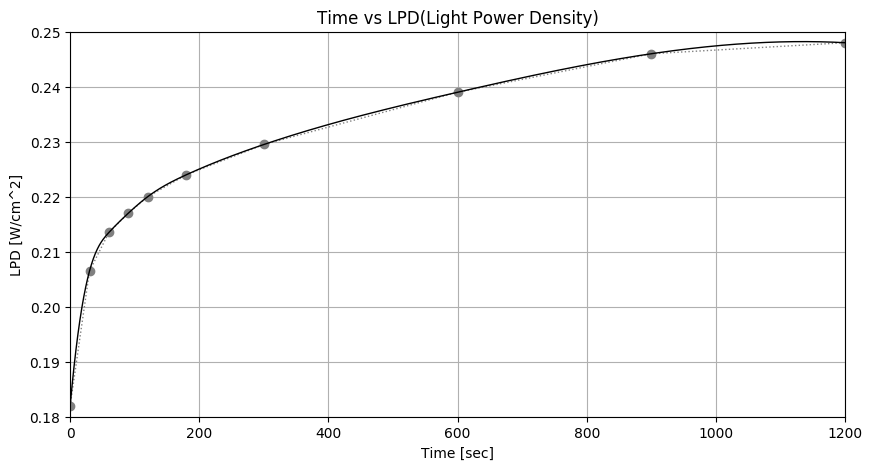

4-element Array{Float64,1}:
    0.0 
 1200.0 
    0.18
    0.25

In [4]:
# Time vs LPD(Light Power Density)
f=figure(figsize=(10,5))
grid("on")
title("Time vs LPD(Light Power Density)")
xlabel("Time [sec]")
ylabel("LPD [W/cm^2]")

x = [0, 30, 60, 90, 120, 180, 300, 600, 900, 1200]; # [sec]
y = [0.182, 0.2065, 0.2135, 0.217, 0.22, 0.224, 0.2295, 0.239, 0.246, 0.248]; # [W/cm^2]
plot(x, y, color="gray", linestyle=":",  marker="o", linewidth=1)

# Interpolation Funcion Name : LPD()
LPD = Spline1D(x,y)
xx = linspace(0,1200,1201)
yy = y[1];
for i = 1:length(xx)-1
    yy = [yy; LPD(i)]
end
plot(xx,yy, color="black", linestyle="-", linewidth=1)
axis([0, 1200, 0.18, 0.25])


## Sensor vs Junction Temperature

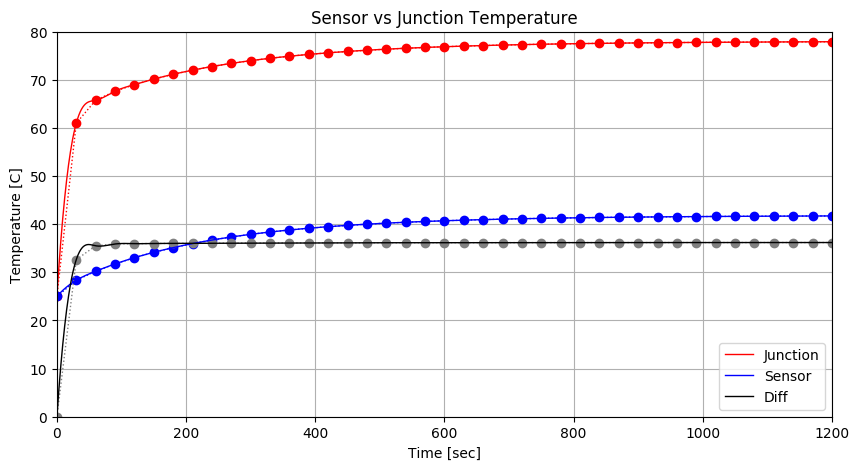

PyObject <matplotlib.legend.Legend object at 0x7efeefe877b8>

In [5]:
# Sensor vs Junction Temperature
f=figure(figsize=(10,5))
grid("on")
title("Sensor vs Junction Temperature")
xlabel("Time [sec]")
ylabel("Temperature [C]")

x2 = [0:30:1800;];
y2_Junction = [25.000, 60.998, 65.754, 67.636, 69.004, 70.157, 71.153, 72.017, 72.767, 73.419, 73.987, 74.481, 74.911, 75.287, 75.615, 75.902, 76.153, 76.373, 76.565, 76.735, 76.883, 77.014, 77.129, 77.230, 77.320, 77.399, 77.469, 77.530, 77.585, 77.634, 77.677, 77.715, 77.749, 77.780, 77.807, 77.831, 77.853, 77.872, 77.890, 77.906, 77.920, 77.932, 77.944, 77.954, 77.964, 77.972, 77.980, 77.987, 77.993, 77.999, 78.004, 78.009, 78.014, 78.018, 78.021, 78.025, 78.028, 78.031, 78.034, 78.036, 78.039];
y2_Sensor = [25.000, 28.358, 30.233, 31.745, 33.042, 34.164, 35.136, 35.979, 36.711, 37.347, 37.900, 38.381, 38.801, 39.167, 39.486, 39.765, 40.010, 40.223, 40.411, 40.575, 40.719, 40.846, 40.958, 41.056, 41.143, 41.220, 41.287, 41.347, 41.400, 41.447, 41.489, 41.526, 41.559, 41.588, 41.615, 41.638, 41.659, 41.678, 41.695, 41.710, 41.724, 41.736, 41.747, 41.757, 41.766, 41.774, 41.782, 41.788, 41.795, 41.800, 41.805, 41.810, 41.814, 41.818, 41.822, 41.825, 41.828, 41.831, 41.834, 41.836, 41.838];
y2_Diff = y2_Junction-y2_Sensor;

plot(x2,y2_Junction, color="red", linestyle=":", marker="o", linewidth=1)
plot(x2,y2_Sensor, color="blue", linestyle=":",  marker="o", linewidth=1)
plot(x2,y2_Diff, color="gray", linestyle=":",  marker="o", linewidth=1)

# Interpolation Funcion Name : JUNCTION(), SENSOR(), DIFF()
JUNCTION = Spline1D(x2,y2_Junction)
SENSOR = Spline1D(x2,y2_Sensor)
DIFF = Spline1D(x2,y2_Diff)
xx2 = linspace(0,1800,1801)
yy2_Junction = y2_Junction[1];
yy2_Sensor = y2_Sensor[1];
yy2_Diff = y2_Diff[1];
for i = 1:length(xx2)-1
    yy2_Junction = [yy2_Junction; JUNCTION(i)]
    yy2_Sensor = [yy2_Sensor; SENSOR(i)]
    yy2_Diff = [yy2_Diff; DIFF(i)]
end
plot(xx2,yy2_Junction, label="Junction", color="red", linestyle="-", linewidth=1)
plot(xx2,yy2_Sensor, label="Sensor", color="blue", linestyle="-", linewidth=1)
plot(xx2,yy2_Diff, label="Diff", color="black", linestyle="-", linewidth=1)
axis([0, 1200, 0, 80])
legend()


## Sensor vs LPD

### 데이타 살펴보기
* 일단 앞서 얻어낸 데이타 중에서 실제 시스템에서 직접 측정 가능한 것들을 추출해 본다.
* 센서온도, 광출력밀도

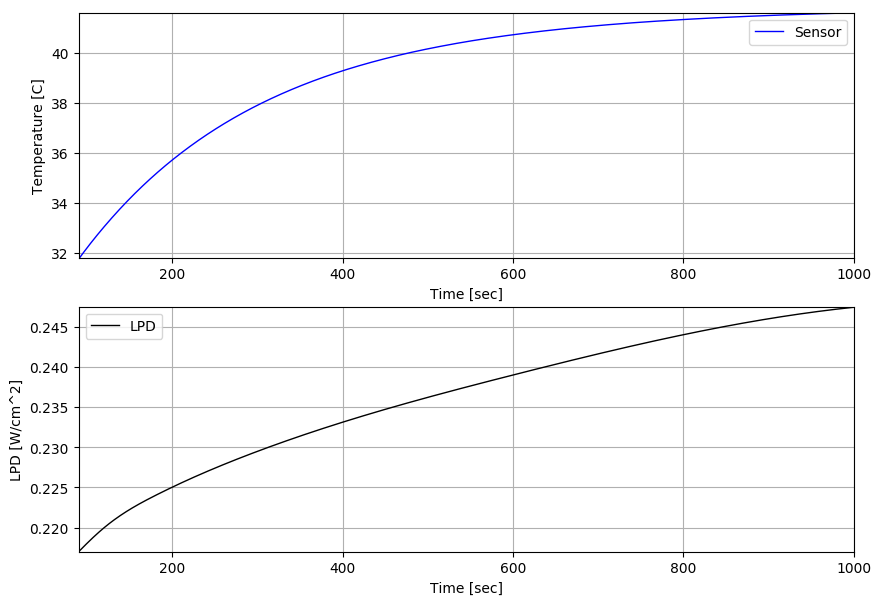

PyObject <matplotlib.legend.Legend object at 0x7efeefde5048>

In [6]:
# Sensor vs LPD
f=figure(figsize=(10,7))

subplot(211)
grid("on")
xlabel("Time [sec]")
ylabel("Temperature [C]")
plot(xx2,yy2_Sensor, label="Sensor", color="blue", linestyle="-", linewidth=1)
axis([90, 1000, 31.8, 41.6])
legend()

subplot(212)
grid("on")
xlabel("Time [sec]")
ylabel("LPD [W/cm^2]")
plot(xx,yy, label="LPD", color="black", linestyle="-", linewidth=1)
axis([90, 1000, 0.217, 0.2475])
legend()


### 위 2개의 그래프에서 판단 가능한 사항들
* 광출력밀도는 온도 이외의 다른 파라미터의 영향도 분명히 존재하는 것으로 보인다.
* 그럼에도 불구하고, 그것이 무엇인지 정확히 규명하기가 어렵기 때문에, 다른 파라미터의 영향은 무시하기로 한다.
* 센서온도와 광출력밀도간의 관계는 비선형적으로 나타난다.
* 일단 그래프를 플랏해 보자.

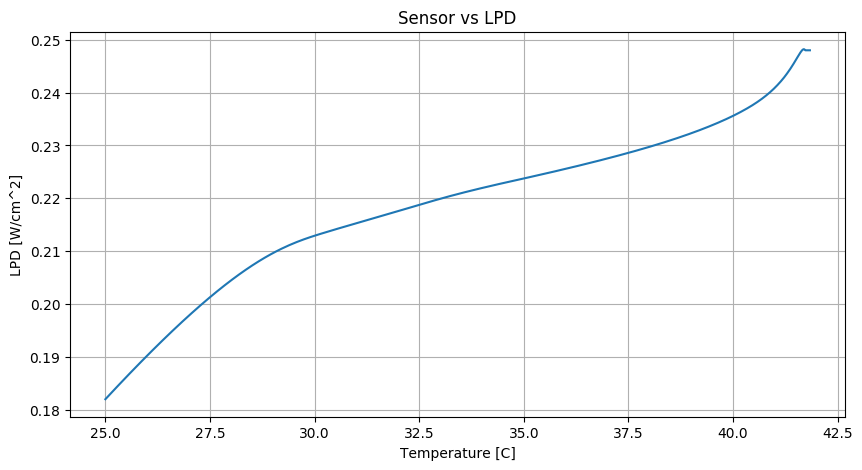

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efeefde5f28>

In [7]:
x3 = [0:1:1800;];

x3_Sensor = SENSOR(0);
for i = 1:length(x3)-1
    x3_Sensor = [x3_Sensor; SENSOR(i)]
end

y3_LPD = LPD(0);
for i = 1:length(x3)-1
    y3_LPD = [y3_LPD; LPD(i)]
end

f=figure(figsize=(10,5))
grid("on")
title("Sensor vs LPD")
xlabel("Temperature [C]")
ylabel("LPD [W/cm^2]")
plot(x3_Sensor, y3_LPD)

### Curve Fitting
* 위와 같이, 센서온도와 광출력밀도의 관계식를 그려보면 약간의 비선형적인 비례관계를 볼 수 있다.
* 이것을 1차 직선 커브피팅으로 근사화해 본다.
* (어차피 실제 하드웨어에서의 해상도가 낮고 정수화된 데이타로 취급해야 하기 때문에 고정밀 데이타까지는 필요 없으므로, 1차 선형 피팅만으로도 충분하다)

In [8]:
# y = a + b*x
a, b = linear_fit(x3_Sensor, y3_LPD)

2-element Array{Float64,1}:
 0.108461  
 0.00329649

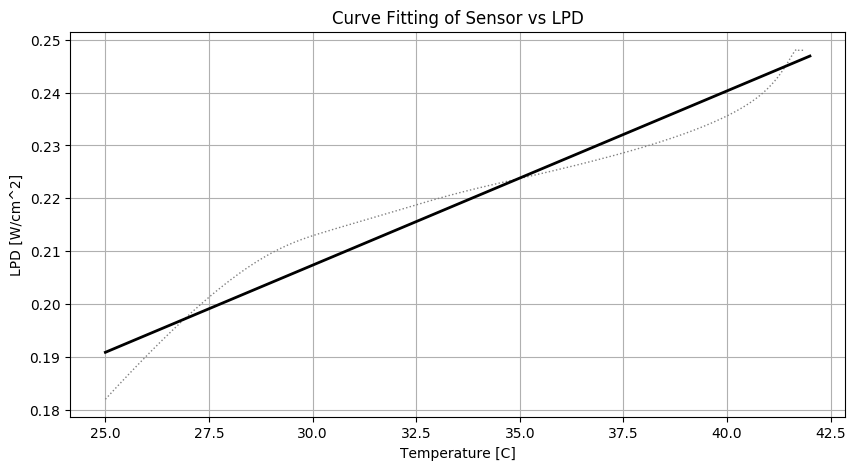

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efeefd8edd8>

In [9]:
x4_Sensor = [25:1:42;];
y4_LPD = a + b*x4_Sensor;

f=figure(figsize=(10,5))
grid("on")
title("Curve Fitting of Sensor vs LPD")
xlabel("Temperature [C]")
ylabel("LPD [W/cm^2]")
plot(x3_Sensor, y3_LPD, label="Raw Data", color="gray", linestyle=":", linewidth=1)
plot(x4_Sensor, y4_LPD, label="Curve Fitting", color="black", linestyle="-", linewidth=2)

## 데이타 단위의 정수화

### 필요성
* 저가형의 8비트 마이크로 프로세서에는 부동소수점 연산 능력이 없다.
* C 라이브러리에서 제공하는 부동소수점 연산 함수를 사용하는 것은 매우 비효율적이다.
* 따라서 취급하는 데이타를 정수화하여 단순 사칙연산만으로 다룰 수 있도록 해 주는 것이 좋겠다.

### 파라미터의 정수화

#### 온도센서값(Sensor)
* 8비트 해상도로 가정한다. (255단계)
* 온도범위는 0~100도씨로 한다.
* 따라서 1단계당 온도차는 $ 100/255 = 0.392156863 [C]$ 가 된다.

$$ TEMPERATURE = INTEGER \left( \frac {SensorTemperature[C]} {0.392156863} \right) $$

#### 광출력밀도(LPD)
* 8비트 해상도로 가정한다. (255단계)
* 출력범위는 0~0.5[W/cm^2]으로 한다.
* 따라서 1단계당 온도차는 $ 0.5/255 = 0.001960784 [W/cm^2] $이 된다.

$$ POWER = INTEGER \left( \frac {LPD[W/cm^2]} {0.001960784} \right) $$

#### 시간(Time)
* 타이머는 1[Hz]으로 가정한다. (1[sec])
* 만일 타이머 인터럽트가 1[kHz] 또는 그 이상일 경우, 매번 증분시키면 값이 지나치게 커져서 정수범위를 벗어나는 문제점이 있다.
* 타이머 인터럽트 1회당 1단계 증분시킨다.

$$ TIME = INTEGER \left( \frac {Time[sec]} {1} \right) $$

#### 커브피팅 계수
* 상수항 a 계수는 0.108461 이고, 기울기 b 계수는 0.00329649 이다.
* Sensor 및 LPD 정수변환한 것을 반영하고, 배율을 100배 스케일링해 주면 다음과 같이 된다.

$$ A = INTEGER \left( 100 \times \frac {a}{0.5/255} \right) = 5531 $$
$$ B = INTEGER \left( 100 \times b \times \frac {100/255}{0.5/255} \right) = 65 $$

### Notations

#### Float

$$ Dose = 0.2 [W/cm^2] \times 900 [sec] = 180 [J/cm^2] $$
$$ a = 0.108461 $$
$$ b = 0.00329649 $$

$$ Dose[J/cm^2] = LPD[W/cm^2] \times Time[sec] $$

$$ Dose[J/cm^2] = \int _0 ^{Time[sec]} { ( a + b \times SensorTemperature[C] ) } $$

#### Integer

$$ DOSE = LONG.INTEGER \left( \frac{0.2[W/cm^2]}{0.001960784} \times \frac{900[sec]}{0.001} \right) = 91800015 $$

$$ A = 5531 $$
$$ B = 65 $$

$$ DOSE = POWER \times TIME $$

$$ DOSE = \int _0 ^{TIME} { ( A + B \times TEMPERATURE ) } $$

### Pseudo Code (Simulation)

In [77]:
# Warning : Long Execution Time caused by Very Large Array

# Parameters
Timer = 1.0;
Scale = 100;
DOSE = floor(Int32, Scale*(0.2/(0.5/255))*(900/Timer) )
a = 0.108461;
b = 0.00329649;
A = floor(Int32, Scale*a/(0.5/255));
B = floor(Int32, Scale*b*(100/255)/(0.5/255));

# Pseudo Temperature Data
xx4 = linspace(0,1800,1801*Timer) # Very Large Array
yy4_Sensor = y2_Sensor[1];
for i = 1:length(xx4)
    yy4_Sensor = [yy4_Sensor; SENSOR(i)]
end
TEMPERATURE = floor(Int32, yy4_Sensor/(100/255));

# Integration
DOSE_INTEGRAL = Int32(0);
TIME = Int32(0);
while DOSE_INTEGRAL < DOSE
    TIME += 1
    DOSE_INTEGRAL = DOSE_INTEGRAL + Int32(A+B*(TEMPERATURE[TIME]))
end


In [78]:
# 소요시간 [sec]
TIME

783

In [79]:
# 실제투여량
DOSE_INTEGRAL

9182373

In [80]:
# 목표투여량
DOSE

9180000

In [81]:
# 최종 투여량 환산
Dose = DOSE_INTEGRAL*Timer*(0.5/255);
Time = TIME*Timer;
print("Dose : ",Dose,"[J/cm^2] during ",Time,"[sec]")

Dose : 18004.65294117647[J/cm^2] during 783.0[sec]

## 결론

* 투여량 $180[J/cm^2]$으로 설정할 경우, 약 783초(13분) 소요되는 것으로 나타난다.
* 예제 데이타로는 이론상 15분 소요되는 것 보다 약 2분 단축된다. (실제 상황에서, 연속 사용시에는 더 단축될 것이다.)
* 온도가 전반적으로 상승할 경우, 시간이 좀 더 단축되는 경향으로 나타날 것이다.
* 온도제어를 통해 리밋온도 50[C] 보다 상승할 때 강제 off 시킬 경우, 냉각시간만큼 시간이 더 길어지게 된다.
* 실험적으로 냉각시간은 약 2분 가량으로 나타난다.